In [85]:
import pickle as pkl
import numpy as np
import os
# import jax
from matplotlib import pyplot as plt
import json

In [78]:
INPUT_FOLDER = "/Users/evanpan/Documents/GitHub/EyeIK/Juggling/juggling_TAP_output"
OUTPUT_FOLDER = "/Users/evanpan/Documents/GitHub/EyeIK/Juggling/juggling_TAP_output"
file_name = "alternating_column_output"

# alternative_column_output is good
# 

In [41]:
file_path = os.path.join(INPUT_FOLDER, file_name + ".pkl")
with open(file_path, 'rb') as f:
    data = pkl.load(f)

# analyze the data and obtain the 2D path of the three balls

/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


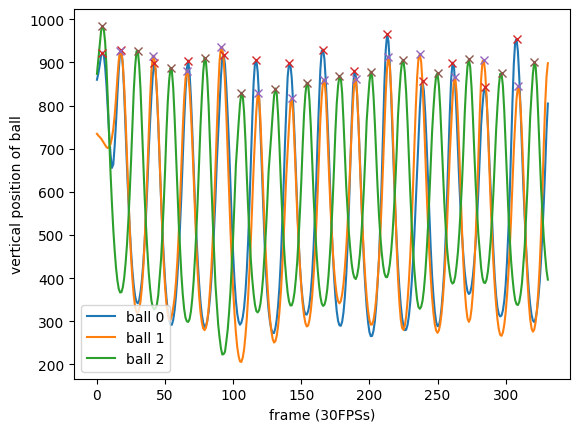

/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


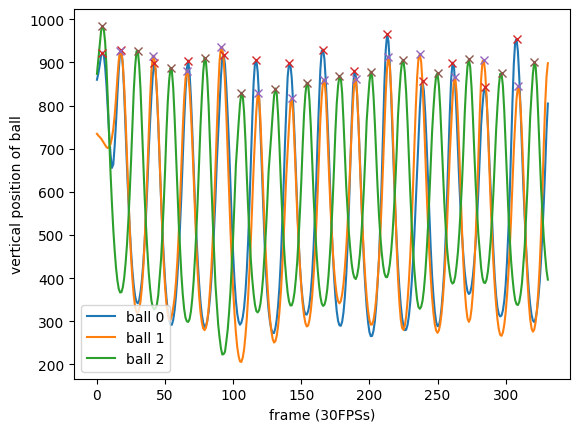

/Users/evanpan/opt/anaconda3/envs/mediapipe/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


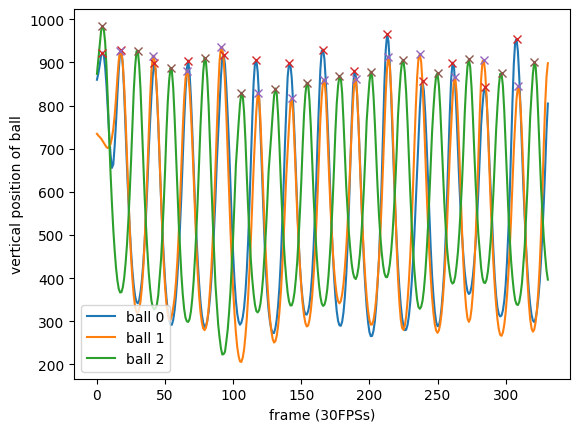

In [87]:
def obtain_ball_position_data(data, fps=30):
    # get the visibility and trajectory
    visibility = data['visibles'] # shape (num_balls, num_frames)
    trajectory = data['tracks'] # shape (num_balls, num_frames, 2)

    ones = np.ones(visibility.shape)
    zeros = np.zeros(visibility.shape)
    visibility_int = np.where(visibility, ones, zeros)
    visibility_int = visibility_int.sum(axis=0)
    # pick a frame with all 3 balls visible, and identify 3 clusters
    for i in range(visibility.shape[1]):
        if visibility_int[i] == visibility.shape[0]:
            frame = i
            break
    # cluster ball by position on this frame
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=3, random_state=0).fit(trajectory[:, frame, :])
    ball_indices = []
    # get the indices of the balls assigned to each ball
    for i in range(0, 3):
        ball_indices.append(np.where(kmeans.labels_ == i)[0])
    # get the trajectory of each ball

    ball_positions = []
    time = np.arange(0, trajectory.shape[1] / fps, 1 / fps)
    for i in range(0, 3):
        traj_ball_i = trajectory[ball_indices[i], :, :]
        traj_ball_mean = []
        for j in range(0, traj_ball_i.shape[1]):
            traj_ball_mean.append(np.mean(traj_ball_i[:, j, :], axis=0))
        traj_ball_mean = np.array(traj_ball_mean)
        ball_positions.append(traj_ball_mean)
        plt.plot(traj_ball_mean[:, 1], label=f"ball {i}")
    
    return time, ball_positions
def get_look_at_point_peak(ball_positions, time):
    look_at = np.zeros(len(time))
    # first, get the local maximum of each ball in dim=1
    peak_indices = []
    # these are stored in peak_indices as a one_hot series
    for i in range(0, len(ball_positions)):
        peak_indice_i = np.zeros(ball_positions[i].shape[0])
        # use scipy to find local maximum
        from scipy.signal import find_peaks
        peaks, _ = find_peaks(ball_positions[i][:, 1])
        # plot on the trajectory
        plt.plot(time[peaks] * 30, ball_positions[i][peaks, 1], "x")
        peak_indice_i[peaks] = 1
        peak_indices.append(peak_indice_i)
        # print(peak_indice_i)

    # now, we need to determine which ball is being looked at at each time point
    looking_at = 0 # we assume it also starts from ball 0
    # this is a temp variable used to track if ANY ball is peaking
    peaking = np.sum(np.array(peak_indices), axis=0)
    for i in range(0, len(time)):
        if peaking[i] >= 1:
            for j in range(0, len(peak_indices)):
                if peak_indices[j][i] == 1:
                    looking_at = j
                    break
        look_at[i] = looking_at
    return look_at
def get_look_at_point(ball_positions, time, approach="peak"):
    # look_at will specifu which ball is being looked at at each time point
    if approach == "peak":
        return get_look_at_point_peak(ball_positions, time)
    else:
        raise ValueError("approach not implemented")
def export_all_points(output_path, time, ball_positions, look_at_indice):
    # the input points are in xy coordinates, needs to convert them to x, y, z world coordinates
    # ===============================
    # TODO: implement the conversion
    # ===============================
    
    output_json = {}
    # make sure each list is a list
    output_json["time"] = time.tolist()
    for i in range(0, 3):
        output_json[f"ball_{i}_positions"] = ball_positions[i].tolist()
    output_json["look_at_indices"] = look_at_indice.tolist()
    with open(output_path, 'w') as f:
        json.dump(output_json, f)


for file_name in ["alternating_column_output", "HD_juggle_over_output", "HD_juggle_tennis_fast_output"]:
    time, ball_positions = obtain_ball_position_data(data)
    look_at_indices = get_look_at_point(ball_positions, time, approach="peak")
    output_path = os.path.join(OUTPUT_FOLDER, file_name + "positions.json")
    export_all_points(output_path, time, ball_positions, look_at_indices)
    plt.legend()
    plt.ylabel("vertical position of ball")
    plt.xlabel("frame (30FPSs)")
    plt.show()